In [1]:
import awkward as ak

# we suppress ROOT warnings where our input ROOT tree has duplicate branches - these are handled correctly.
import warnings
warnings.filterwarnings("ignore", message="Found duplicate branch ")

In [2]:
def getParticles(genparticles,lowid=22,highid=25,flags=['fromHardProcess', 'isLastCopy']):
    """
    returns the particle objects that satisfy a low id, 
    high id condition and have certain flags
    """
    absid = abs(genparticles.pdgId)
    return genparticles[
        ((absid >= lowid) & (absid <= highid))
        & genparticles.hasFlags(flags)
    ]

def match_HWWlepqq(genparticles,candidatefj):
    """
    return the number of matched objects (hWW*),daughters, 
    and gen flavor (enuqq, munuqq, taunuqq) 
    """
    W_PDGID = 24
    HIGGS_PDGID = 25
    higgs = getParticles(genparticles,HIGGS_PDGID)
    is_hWW = ak.all(abs(higgs.children.pdgId)==W_PDGID,axis=2)

    higgs = higgs[is_hWW]
    higgs_wstar = higgs.children[ak.argmin(higgs.children.mass,axis=2,keepdims=True)]
    higgs_w = higgs.children[ak.argmax(higgs.children.mass,axis=2,keepdims=True)]
    
    prompt_electron = getParticles(genparticles,11,11,['isPrompt','isLastCopy'])
    prompt_muon = getParticles(genparticles,13,13,['isPrompt', 'isLastCopy'])
    prompt_tau = getParticles(genparticles,15,15,['isPrompt', 'isLastCopy'])
    prompt_q = getParticles(genparticles,0,5,['fromHardProcess', 'isLastCopy'])
    prompt_q = prompt_q[abs(prompt_q.distinctParent.pdgId) == W_PDGID]
    
    dr_fj_quarks = candidatefj.delta_r(prompt_q)
    dr_fj_electrons = candidatefj.delta_r(prompt_electron)
    dr_fj_muons = candidatefj.delta_r(prompt_muon)
    dr_fj_taus = candidatefj.delta_r(prompt_tau)
    dr_daughters = ak.concatenate([dr_fj_quarks,dr_fj_electrons,dr_fj_muons,dr_fj_taus],axis=1)
    hWWlepqq_nprongs = ak.sum(dr_daughters<0.8,axis=1)
    
    n_electrons = ak.sum(prompt_electron.pt>0,axis=1)
    n_muons = ak.sum(prompt_muon.pt>0,axis=1)
    n_taus = ak.sum(prompt_tau.pt>0,axis=1)
    n_quarks = ak.sum(prompt_q.pt>0,axis=1)

    # 4(elenuqq),6(munuqq),8(taunuqq)
    hWWlepqq_flavor = (n_quarks==2)*1 + (n_electrons==1)*3 + (n_muons==1)*5 + (n_taus==1)*7
    
    matchedH = candidatefj.nearest(higgs, axis=1, threshold=0.8)
    matchedW = candidatefj.nearest(higgs_w, axis=1, threshold=0.8)
    matchedWstar = candidatefj.nearest(higgs_wstar, axis=1, threshold=0.8) 

    # 1 (H only), 4(W), 6(W star), 9(H, W and Wstar)
    hWWlepqq_matched = (
        (ak.sum(matchedH.pt > 0, axis=1)==1) * 1 
        + (ak.sum(ak.flatten(matchedW.pt > 0, axis=2), axis=1)==1) * 3 
        + (ak.sum(ak.flatten(matchedWstar.pt > 0, axis=2), axis=1)==1) * 5
    )
    
    # leptons matched
    dr_leptons = ak.concatenate([dr_fj_electrons,dr_fj_muons], axis=1)
    matched_leptons = dr_leptons < 0.8
    
    leptons = ak.concatenate([prompt_electron, prompt_muon], axis=1)
    leptons = leptons[matched_leptons]
    
    # leptons coming from W or W*
    leptons_mass = ak.firsts(leptons.distinctParent.mass)
    higgs_w_mass = ak.firsts(ak.flatten(higgs_w.mass))[ak.firsts(leptons.pt > 0)]
    higgs_wstar_mass = ak.firsts(ak.flatten(higgs_wstar.mass))[ak.firsts(leptons.pt > 0)]

    iswlepton = (leptons_mass == higgs_w_mass)
    iswstarlepton = (leptons_mass == higgs_wstar_mass)
    
    # let's return only:
    # - matchedH (the higgs boson that is matched to the jet)
    # - (iswlepton,iswstarlepton)
    return matchedH,iswlepton,iswstarlepton

In [3]:
import numpy as np
import pandas as pd
from coffea.processor import ProcessorABC, column_accumulator
from coffea.nanoevents.methods import candidate, vector
from coffea.analysis_tools import Weights, PackedSelection
    
class TriggerEfficienciesProcessor(ProcessorABC):
    """ Accumulates histograms from all input events: 1) before triggers, and 2) after triggers """
    def __init__(self, year=2017):
        super(TriggerEfficienciesProcessor, self).__init__()
        self._year = year
        self._trigger_dict = {
            2017:{
                "enominal": [
                    "Ele35_WPTight_Gsf", # electron trigger with isolation
                    "Ele115_CaloIdVT_GsfTrkIdT", # electron trigger without isolation
                ],
                "ejet": [
                    "Ele50_CaloIdVT_GsfTrkIdT_PFJet165"
                ],
                "evvl": [
                    "Ele15_IsoVVVL_PFHT600"
                ],
                "evvlmet": [
                    "Ele15_IsoVVVL_PFHT450_PFMET50"
                ],
                "photon": [
                    "Photon200",
                ],
                "jet": [
                    "PFHT1050",
                    "AK8PFJet400_TrimMass30",
                    "AK8PFJet420_TrimMass30",
                    "AK8PFHT800_TrimMass50",
                    "PFJet500",
                    "AK8PFJet500",
                ],
                "munominal": [
                    "IsoMu27", # muon trigger with isolation
                    "Mu50", # muon trigger without isolation
                ],
                "muvvlmet": [
                    "Mu15_IsoVVVL_PFHT450_PFMET50"
                ],
                "muvvl": [
                    "Mu15_IsoVVVL_PFHT600"
                ],
            }
        }[self._year]
        self._triggers = {"ele": ["enominal","ejet","evvl","evvlmet","jet"],
                          "mu": ["munominal","muvvl","muvvlmet","jet"],
                          "had": ["jet"],
                         }
        
        self._channels = ["ele","mu"]
    
    def pad_val(
        self, arr: ak.Array, target: int, value: float, axis: int = 0, to_numpy: bool = True
    ):
        """pads awkward array up to `target` index along axis `axis` with value `value`, optionally converts to numpy array"""
        ret = ak.fill_none(ak.pad_none(arr, target, axis=axis, clip=True), value)
        return ret.to_numpy() if to_numpy else ret
    
    def process(self, events):
        """ Returns pre- (den) and post- (num) trigger histograms from input NanoAOD events """
        dataset = events.metadata['dataset']
        n_events = len(events)
        isRealData = not hasattr(events, "genWeight")
        
        def pad_val_nevents(arr: ak.Array):
            """pad values with the length equal to the number of events"""
            return self.pad_val(arr, n_events, -1)
    
        # skimmed events for different channels
        out = {}
        for channel in self._channels:
            out[channel] = {}

        """ Save OR of triggers as booleans """
        for channel in self._channels:
            HLT_triggers = {}
            for t in self._triggers[channel]:
                HLT_triggers["HLT_"+t] = np.any(
                        np.array(
                            [
                                events.HLT[trigger] for trigger in self._trigger_dict[t] if trigger in events.HLT.fields
                            ]
                        ),
                        axis=0,
                )                
            out[channel] = {**out[channel], **HLT_triggers}

        """ Baseline selection """
        goodmuon = (
            (events.Muon.pt > 25)
            & (abs(events.Muon.eta) < 2.4)
            & events.Muon.mediumId
        )
        nmuons = ak.sum(goodmuon, axis=1)
        goodelectron = (
            (events.Electron.pt > 25)
            & (abs(events.Electron.eta) < 2.5)
            & (events.Electron.mvaFall17V2noIso_WP90)
        )
        nelectrons = ak.sum(goodelectron, axis=1)
        goodtau = (
            (events.Tau.pt > 20)
            & (abs(events.Tau.eta) < 2.3)
            & (events.Tau.idAntiEle >= 8)
            & (events.Tau.idAntiMu >= 1)
        )
        ntaus = ak.sum(goodtau, axis=1)
        
        # leading lepton
        goodleptons = ak.concatenate([events.Muon[goodmuon], events.Electron[goodelectron]], axis=1)
        candidatelep = ak.firsts(goodleptons[ak.argsort(goodleptons.pt)])
        
        # fatjet closest to MET
        fatjets = events.FatJet
        candidatefj = fatjets[
            (fatjets.pt > 200) &
            (abs(fatjets.eta) < 2.4)
        ]
        met = events.MET
        dphi_met_fj = abs(candidatefj.delta_phi(met))
        candidatefj = ak.firsts(candidatefj[ak.argmin(dphi_met_fj,axis=1,keepdims=True)])
        dr_lep_fj = candidatefj.delta_r(candidatelep)

        # jets
        jets = events.Jet
        candidatejet = jets[
            (jets.pt > 30) 
            & (abs(jets.eta) < 2.5) 
            & jets.isTight
        ]
        
        # define isolation
        mu_iso = ak.where(candidatelep.pt >= 55., candidatelep.miniPFRelIso_all, candidatelep.pfRelIso03_all)
        ele_iso = ak.where(candidatelep.pt >= 120., candidatelep.pfRelIso03_all, candidatelep.pfRelIso03_all)
        
        # define selections for different channels
        for channel in self._channels:
            selection = PackedSelection()
            selection.add('fjkin', candidatefj.pt > 200)
            if channel=="mu":
                selection.add('onemuon', (nmuons == 1) & (nelectrons == 0) & (ntaus == 0))
                selection.add('muonkin', (candidatelep.pt > 27.) & abs(candidatelep.eta < 2.4))
            elif channel=="ele":
                selection.add('oneelectron', (nelectrons == 1) & (nmuons == 0) & (ntaus == 0))
                selection.add('electronkin', (candidatelep.pt > 30.) & abs(candidatelep.eta < 2.4))

            """ Define other variables to save """
            out[channel]["fj_pt"] = pad_val_nevents(candidatefj.pt)
            out[channel]["fj_msoftdrop"] = pad_val_nevents(candidatefj.msoftdrop)
            out[channel]["lep_pt"] = pad_val_nevents(candidatelep.pt)
            if channel=="mu":
                out[channel]["lep_isolation"] = pad_val_nevents(mu_iso)
            elif channel=="ele":
                out[channel]["lep_isolation"] = pad_val_nevents(ele_iso)
            out[channel]["fj_lep_mass"] = pad_val_nevents((candidatefj - candidatelep).mass)
            out[channel]["fj_lep_dR"] = pad_val_nevents(dr_lep_fj)
            out[channel]["ht"] = pad_val_nevents(ak.sum(candidatejet.pt, axis=1))
            
            if "HToWW" in dataset:
                matchedH,iswlepton,iswstarlepton = match_HWWlepqq(events.GenPart,candidatefj)
                matchedH_pt = ak.firsts(matchedH.pt)
            else:
                matchedH_pt = ak.zeros_like(candidatefj.pt)
                iswlepton = ak.ones_like(candidatefj.pt, dtype=bool)
                iswstarlepton = ak.ones_like(candidatefj.pt, dtype=bool)
            out[channel]["higgspt"] = pad_val_nevents(matchedH_pt)
            out[channel]["iswlepton"] = pad_val_nevents(iswlepton)
            out[channel]["iswstarlepton"] = pad_val_nevents(iswstarlepton)

            # use column accumulators
            out[channel] = {
                key: column_accumulator(value[selection.all(*selection.names)])
                for (key, value) in out[channel].items()
            }
        
        return {
            self._year: {
                dataset: {"nevents": n_events, "skimmed_events": out}
            }
        }

                  
    def postprocess(self, accumulator):
        for year, datasets in accumulator.items():
            for dataset, output in datasets.items():
                for channel in output["skimmed_events"].keys():
                    output["skimmed_events"][channel] = {
                        key: value.value for (key, value) in output["skimmed_events"][channel].items()
                    }
                
        return accumulator

In [4]:
# define the client
from dask.distributed import Client

client = Client("tls://localhost:8786")

In [7]:
# define the full fileset
# download this file in a new terminal in coffea casa: 
# wget https://raw.githubusercontent.com/cmantill/boostedhiggs/main/fileset/fileset_2017_UL_NANO.json
# the dataset that we will run on is called: GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8
import json
import uproot
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
dataset_name = "GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8"
with open("/home/cms-jovyan/fileset_2017_UL_NANO.json", 'r') as f:
    files = json.load(f)[dataset_name]
    
fileset = {}
# need to define the fileset but call them with xcache
fileset[dataset_name] = ["root://xcache/"+ f for f in files]

import uproot
uproot.open.defaults['xrootd_handler'] = uproot.source.xrootd.MultithreadedXRootDSource

from coffea.processor import IterativeExecutor,Runner,DaskExecutor

# define processor
p = TriggerEfficienciesProcessor()

# define executor (dask)
# https://coffeateam.github.io/coffea/api/coffea.processor.DaskExecutor.html
executor = DaskExecutor(compression=1, status=True, client=client, treereduction=2)

# define the runner (Same as before)
run = Runner(executor=executor,savemetrics=True,chunksize=10000,schema=NanoAODSchema)

# run
out,metrics = run(fileset,'Events',processor_instance=p)

In [8]:
print(fileset)

{'GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8': ['root://xcache//store/mc/RunIISummer19UL17NanoAODv2/GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8/NANOAODSIM/106X_mc2017_realistic_v8-v1/250000/13D6BBD5-89E3-8647-AED6-FB5DFAAF4C8C.root', 'root://xcache//store/mc/RunIISummer19UL17NanoAODv2/GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8/NANOAODSIM/106X_mc2017_realistic_v8-v1/280000/E3AFEC72-BD60-DF4F-8253-8F2ECCCA6199.root', 'root://xcache//store/mc/RunIISummer19UL17NanoAODv2/GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8/NANOAODSIM/106X_mc2017_realistic_v8-v1/280000/2BB6462D-316F-D94F-A61D-D630DC0EB55C.root', 'root://xcache//store/mc/RunIISummer19UL17NanoAODv2/GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8/NANOAODSIM/106X_mc2017_realistic_v8-v1/270000/AF590A19-8DBD-C94B-B6CF-C9BBB5EA1EF7.root', 'root://xcache//store/mc/RunIISummer19UL17NanoAODv2/GluGluHToW

In [9]:
out

{2017: {'GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8': {'nevents': 11871400, 'skimmed_events': {'ele': {'HLT_enominal': array([ True,  True,  True, ..., False,  True,  True]), 'HLT_ejet': array([ True, False,  True, ..., False,  True,  True]), 'HLT_evvl': array([False, False, False, ..., False, False,  True]), 'HLT_evvlmet': array([False, False, False, ..., False, False, False]), 'HLT_jet': array([False, False, False, ..., False, False, False]), 'fj_pt': array([203.875, 209.25 , 276.25 , ..., 244.75 , 270.   , 308.5  ]), 'fj_msoftdrop': array([  6.02734375,  75.9375    ,   2.38476562, ...,   5.64453125,
       114.875     ,  37.84375   ]), 'lep_pt': array([ 97.84786987, 102.15616608,  89.60289764, ..., 135.48361206,
       123.95256042, 142.64909363]), 'lep_isolation': array([0.01230223, 0.00171016, 0.        , ..., 0.17748882, 0.00306865,
       0.6218999 ]), 'fj_lep_mass': array([        nan, 28.93631935,         nan, ...,         nan,
       76.53757477,

In [ ]:
# you can save now the output!
import pickle

filehandler = open("out_Nov10.hist", "wb")
pickle.dump(out, filehandler)
filehandler.close()

In [11]:
out[2017]["GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8"]["skimmed_events"]["ele"]["fj_pt"][out[2017]["GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8"]["skimmed_events"]["ele"]["fj_pt"] >0]

array([203.875, 209.25 , 276.25 , ..., 244.75 , 270.   , 308.5  ])

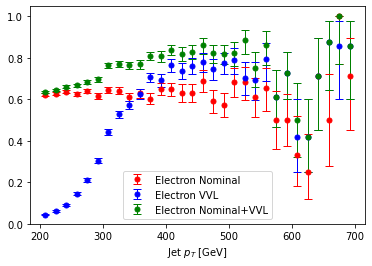

In [15]:
# now we can make a histogram
import hist as hist2
jetpt_axis = hist2.axis.Regular(30, 200, 700, name='jetpt', label=r'Jet $p_T$ [GeV]')
leppt_axis = hist2.axis.Regular(30, 10, 200, name='leppt', label=r'Lepton $p_T$ [GeV]')
hpt_axis = hist2.axis.Regular(50, 10, 800, name='higgspt', label=r'matched H $p_T$ [GeV]')
region_cat = hist2.axis.StrCategory(["numerator","denominator"], name="region")
channel_cat = hist2.axis.StrCategory([], name='channel', growth=True)
trigger_cat = hist2.axis.StrCategory([], name='trigger', growth=True)
ht_axis = hist2.axis.Regular(20,180,2000, name='ht', label=r'HT [GeV]')

hists = {}
hists["jet"] = hist2.Hist(
                channel_cat,
                region_cat,
                trigger_cat,
                jetpt_axis,
            )
# now we can fill the histogram with the denominator (baseline selection already applied)
skimmed_events_ele = out[2017]["GluGluHToWWToLNuQQ_M125_TuneCP5_PSweight_13TeV-powheg2-jhugen727-pythia8"]["skimmed_events"]["ele"]
jetpt = skimmed_events_ele["fj_pt"]

hists["jet"].fill(
    channel="ele",
    region="denominator",
    trigger="all",
    jetpt=jetpt
)
hists["jet"].fill(
    channel="ele",
    region="numerator",
    trigger="nominal",
    jetpt=jetpt[skimmed_events_ele["HLT_enominal"]]
)
hists["jet"].fill(
    channel="ele",
    region="numerator",
    trigger="vvl",
    jetpt=jetpt[skimmed_events_ele["HLT_evvl"]]
)

hists["jet"].fill(
    channel="ele",
    region="numerator",
    trigger="vvl_nominal",
    jetpt=jetpt[skimmed_events_ele["HLT_evvl"] | skimmed_events_ele["HLT_enominal"]]
)

# now we plot
num = hists["jet"][{"region":"numerator","channel":"ele","trigger":"nominal"}]
num_vvl = hists["jet"][{"region":"numerator","channel":"ele","trigger":"vvl"}]
num_all = hists["jet"][{"region":"numerator","channel":"ele","trigger":"vvl_nominal"}]
den = hists["jet"][{"region":"denominator","channel":"ele","trigger":sum}]

import matplotlib.pyplot as plt
import mplhep as hep
from hist.intervals import clopper_pearson_interval
def get_yerr(num,den):
    return abs(clopper_pearson_interval(num.view(), den.view()) - num.view()/den.view())

fig, ax = plt.subplots(1, 1)
hep.histplot(num/den, 
             yerr=get_yerr(num,den),
             ax = ax,
             histtype='errorbar', color='red', capsize=4, elinewidth=1, label="Electron Nominal",         
)
hep.histplot(num_vvl/den, 
             yerr=get_yerr(num_vvl,den),
             ax = ax,
             histtype='errorbar', color='blue', capsize=4, elinewidth=1, label="Electron VVL",         
)
hep.histplot(num_all/den, 
             yerr=get_yerr(num_all,den),
             ax = ax,
             histtype='errorbar', color='green', capsize=4, elinewidth=1, label="Electron Nominal+VVL",         
)
ax.legend()